# Setup

In [1]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import scipy
from scipy.stats import norm
import re

In [2]:
input_folder = r'\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data'
input_file = r'JUV011\211215\JUV011-211215-gonogo-001.hdf5'

In [3]:
hfile = os.path.join(input_folder, input_file)
hf = h5py.File(hfile, 'r')
hf.keys()

<KeysViewHDF5 ['dff', 'dims', 'dview', 'estimates', 'mmap_file', 'params', 'remove_very_bad_comps', 'skip_refinement', 'snr']>

# Spatial Components ('A' matrix)

In [4]:
# A is stored as a scipy.sparse.csc_matrix
def load_A(hf):
    if 'estimates' in hf:
        A = hf['estimates']['A']
    else:
        A = hf['Nsparse']
    data = A['data']
    indices = A['indices']
    indptr = A['indptr']
    return csc_matrix((data, indices, indptr), A['shape'])


A = load_A(hf)
A.shape

(44944, 161)

In [5]:
dims = np.array(hf['dims'])
dims.tolist()

[212, 212]

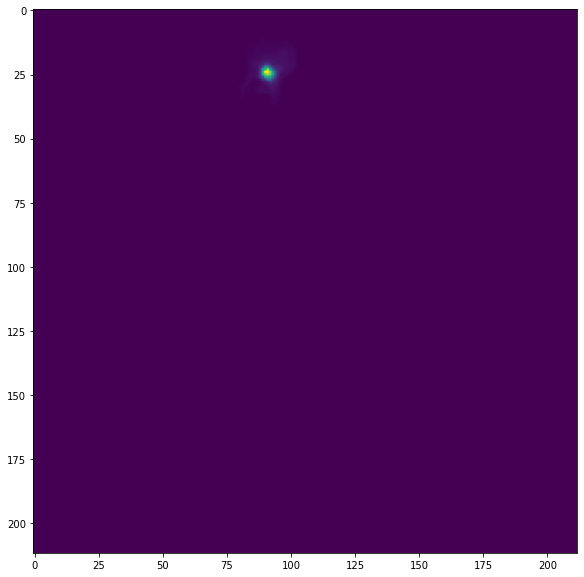

In [6]:
roi_index = 157
plt.figure(figsize=(10, 10))
plt.imshow(A.toarray()[:, roi_index].reshape(dims, order='F'))

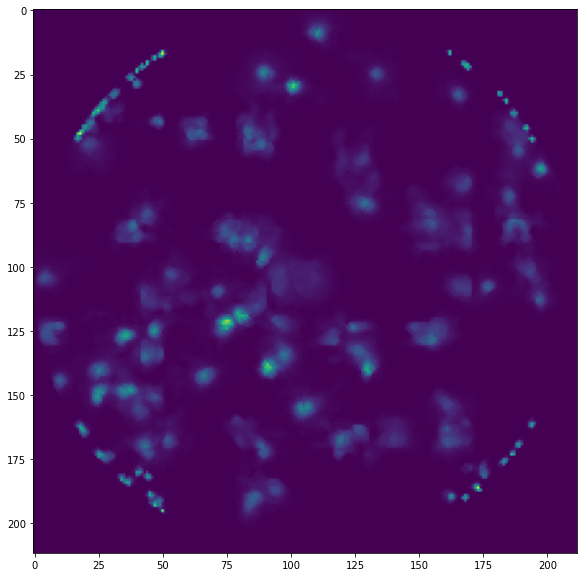

In [7]:
roi_aggregate = np.sum(A, axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(roi_aggregate.reshape(dims, order='F'))

### Filter ROIs using SNR

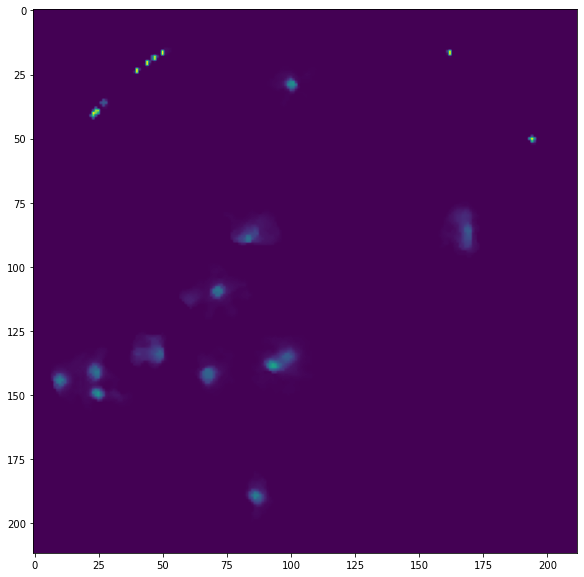

In [8]:
# will only add ROI's with SNR greater than this value
snr_cutoff = 7
n_rois = A.shape[1]
roi_filter_aggregate = np.zeros(shape=(A.shape[0], 1))
np.array(hf['snr'])
total = 0
for i in range(n_rois):
    if hf['snr'][i] > snr_cutoff:
        roi_filter_aggregate += A[:, i]
        total += 1
plt.figure(figsize=(10, 10))
plt.imshow(roi_filter_aggregate.reshape(dims, order='F'))

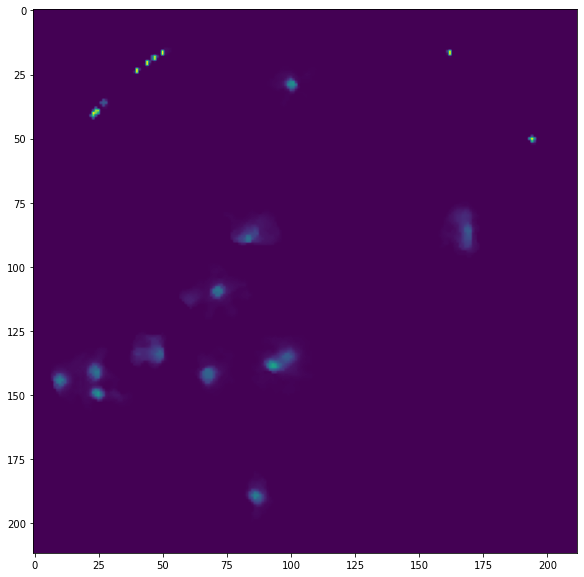

In [9]:
roi_fast = A[:, np.array(hf['snr']) > snr_cutoff].sum(axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(roi_fast.reshape(dims, order='F'))

# Temporal Components ('C' Matrix)

In [10]:
C = np.array(hf['estimates/C'])
C.shape

(161, 36000)

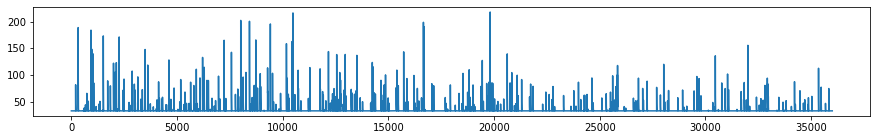

In [11]:
roi_index = 157
plt.figure(figsize=(15, 2))
plt.plot(C[roi_index])

### Find 'n' most active ROI's

In [12]:
n = 5
np.argpartition(np.std(C, axis=1), -n)[-n:].tolist()

[154, 100, 56, 99, 102]

# CaImAn Parameter Comparison

In [19]:
param_names = ['K', 'rf', 'stride_cnmf', 'gnb']
def param_string(params):
    return ', '.join([a + " = " + str(b) for a, b in zip(param_names, params)])

def roi_output(hfile):
    hf = h5py.File(hfile, 'r')
    dims = np.array(hf['dims'])
    A = load_A(hf)
    roi_aggregate = np.sum(A, axis=1)
    return roi_aggregate.reshape(dims, order='F')

def get_C(hfile):
    hf = h5py.File(hfile, 'r')
    C = np.array(hf['estimates/C'])
    return C

def get_dff(hfile):
    hf = h5py.File(hfile, 'r')
    dff = np.array(hf['dff'])
    return dff

In [14]:
input_folder = r'C:\Users\right\Desktop\lab\hard drive\madeline_data_output_3'
files = list(filter(lambda f: f.endswith('.hdf5'), os.listdir(input_folder)))
p = re.compile(r'^(.*)-(.*)-gonogo-001_(\d*)-(\d*)-(\d*).hdf5')

In [15]:
cols = 4
rows = len(files) // cols

## Spatial Comparison

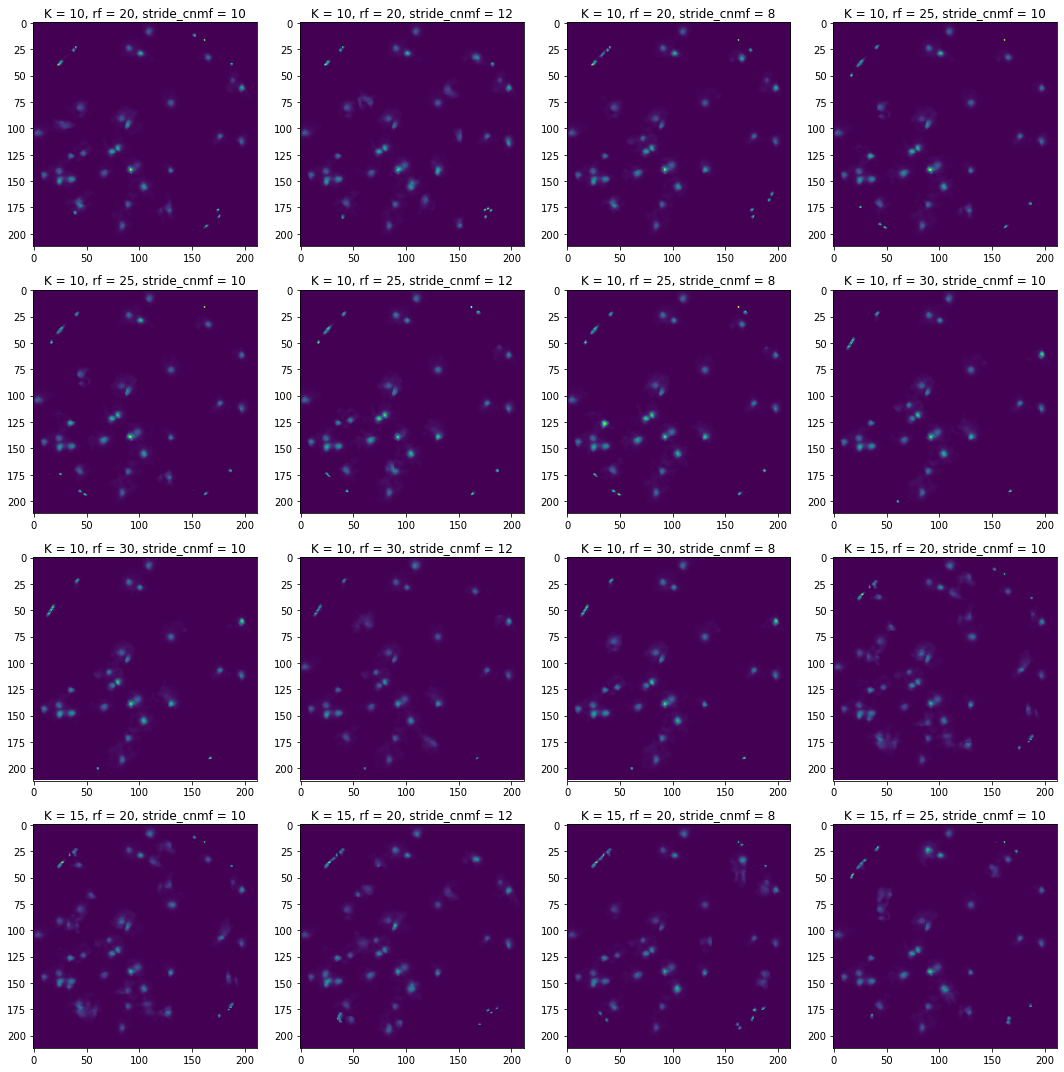

In [16]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
for i in range(rows):
    for j in range(cols):
        file_name = files[3*i+j]
        file = os.path.join(input_folder, file_name)
        axes[i][j].set_title(param_string(p.match(file_name).groups()[2:]))
        axes[i][j].imshow(roi_output(file))
fig.tight_layout()

## Temporal Comparison

D:\Programs\anaconda3\envs\caiman\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


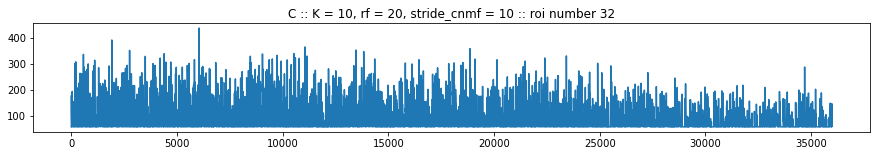

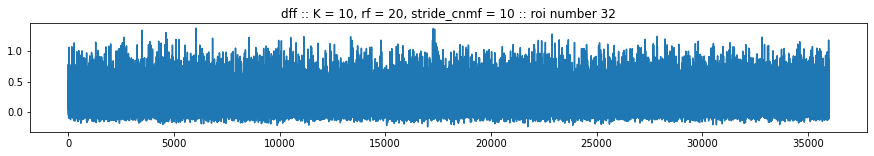

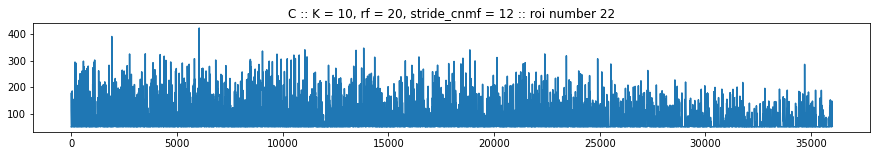

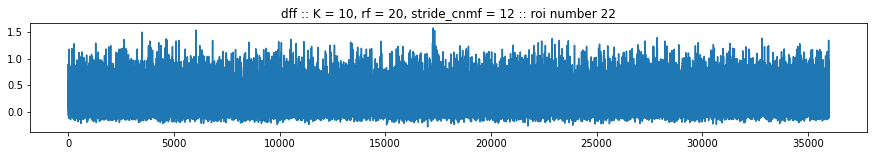

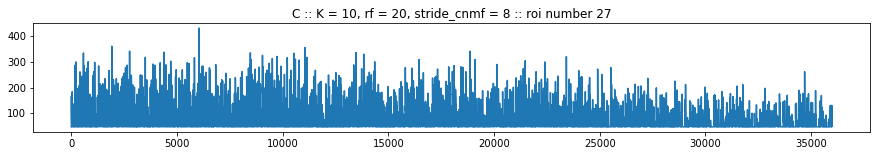

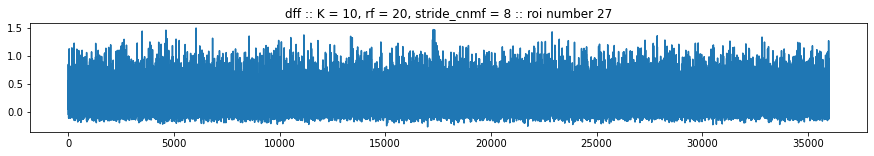

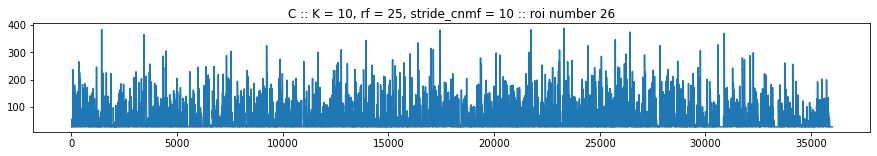

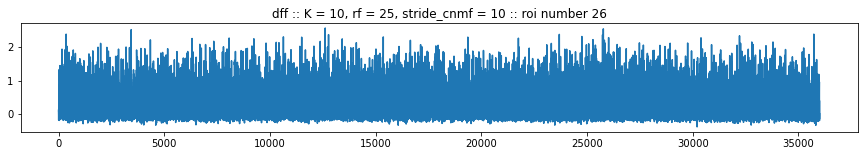

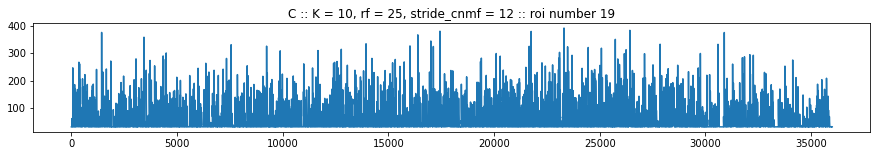

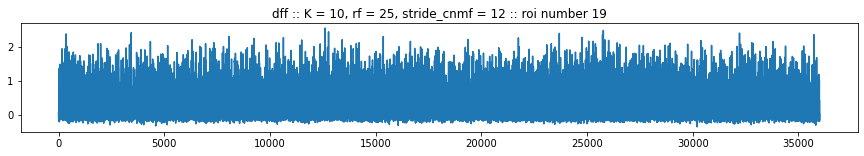

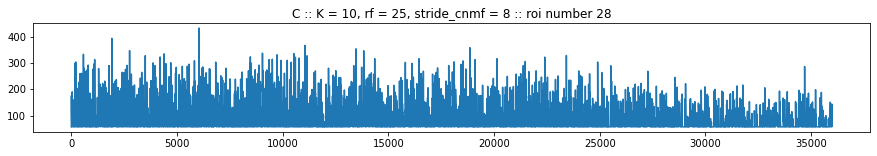

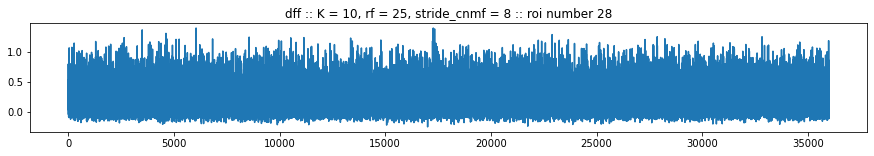

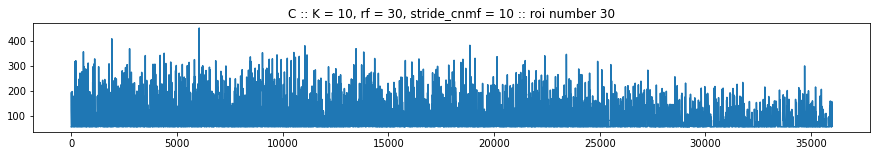

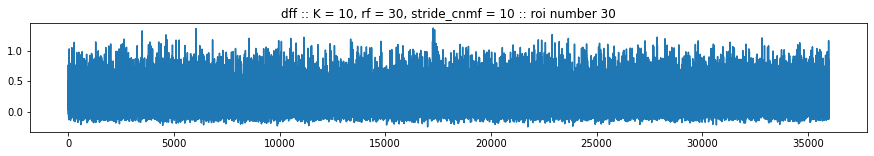

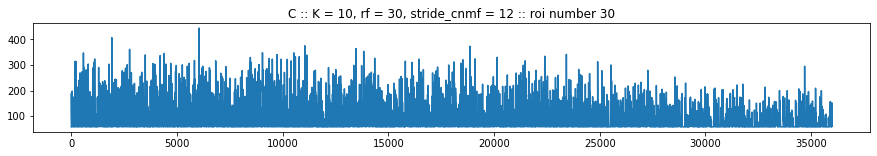

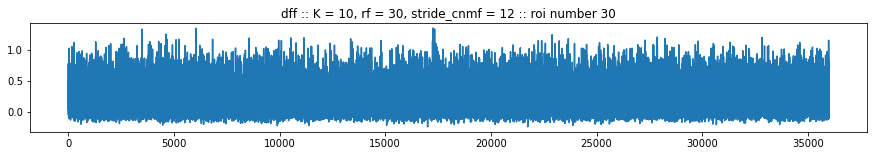

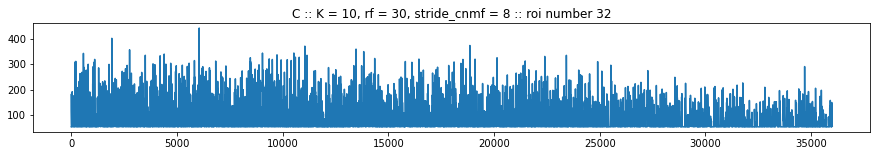

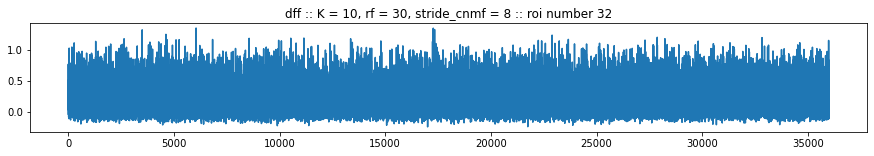

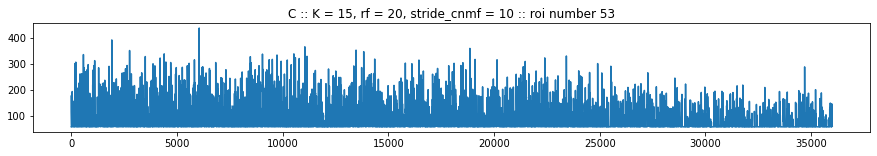

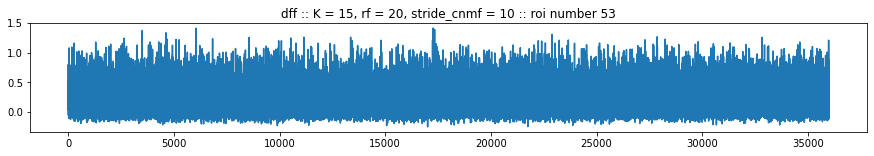

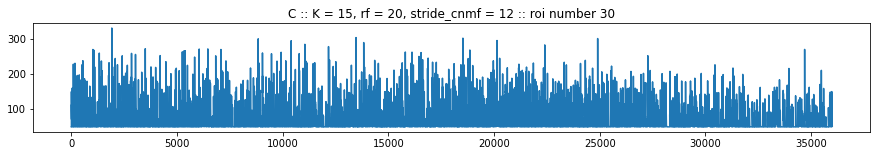

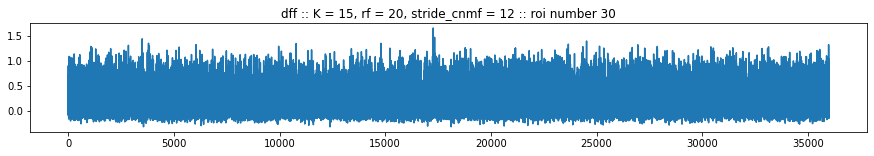

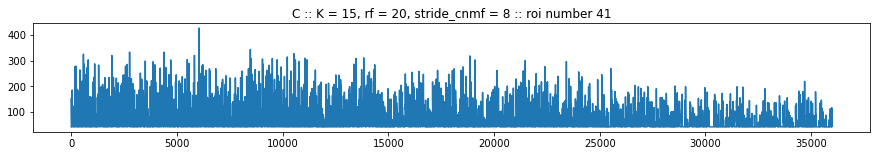

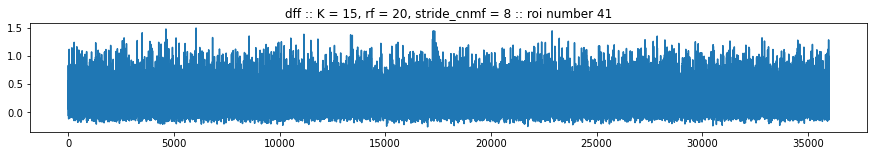

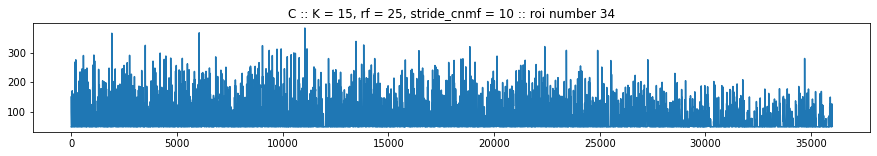

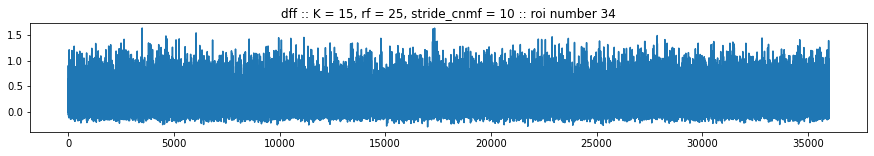

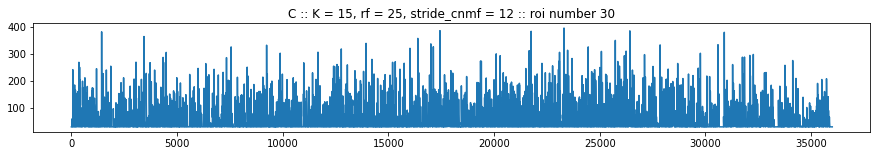

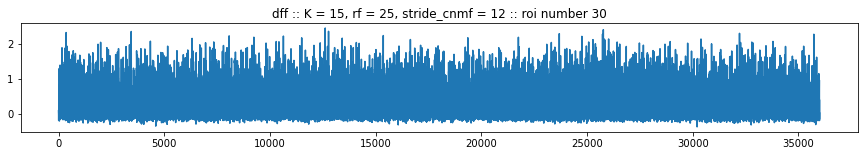

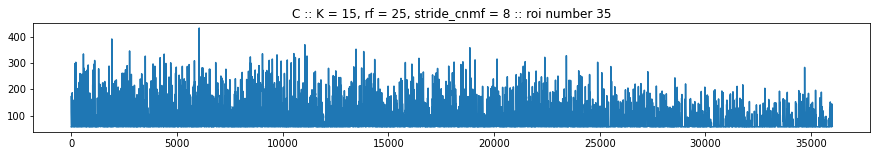

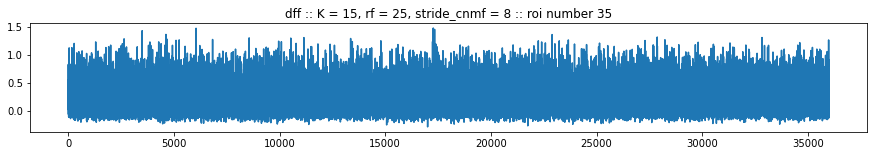

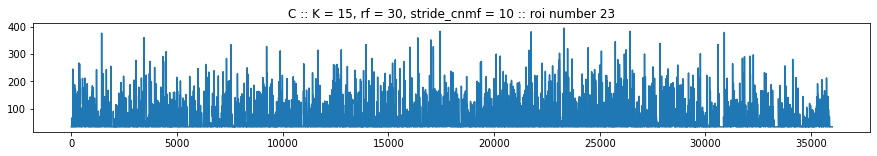

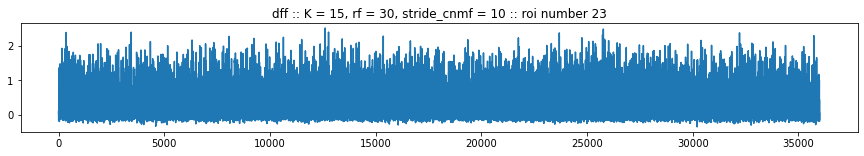

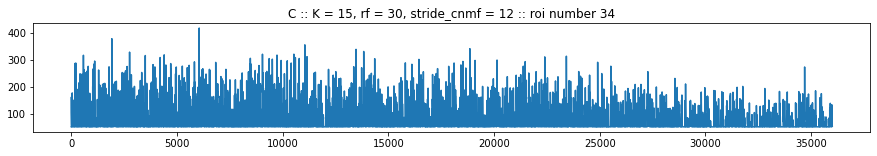

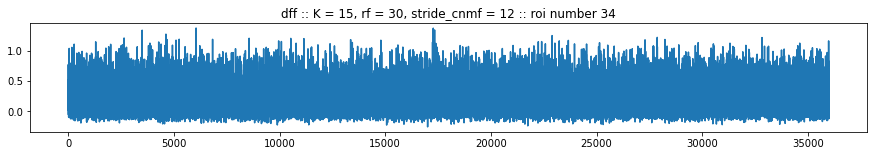

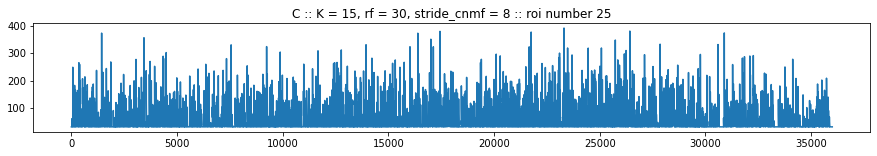

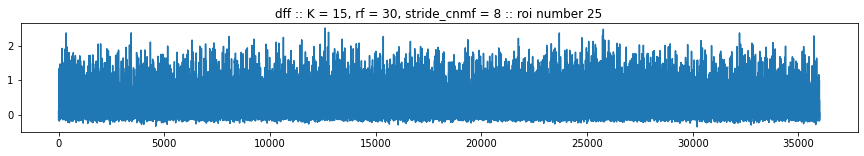

In [23]:
# Plot the C and dff of the most active ROI for each hfile
for file in files:
    # get C and dff
    C = get_C(os.path.join(input_folder, file))
    dff = get_dff(os.path.join(input_folder, file))
    # get most active ROI
    roi = np.argpartition(np.std(C, axis=1), -1)[-1:].tolist()
    # plot C
    plt.figure(figsize=(15, 2))
    plt.title('C :: ' + param_string(p.match(file).groups()[2:]) + ' :: roi number ' + str(roi[0]))
    plt.plot(C[roi[0]])
    plt.figure(figsize=(15, 2))
    plt.title('dff :: ' + param_string(p.match(file).groups()[2:]) + ' :: roi number ' + str(roi[0]))
    plt.plot(dff[roi[0]])